<a href="https://colab.research.google.com/github/JaganFoundr/PyTorchNN/blob/main/Generative%20Adverserial%20NN/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [96]:
#1
import torch
import torchvision
from torchvision.datasets import MNIST
import torchvision.transforms as tt
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import DataLoader

In [97]:
#2
dataset=MNIST(root='./data', download=True, train=True,transform=tt.Compose([tt.ToTensor(),
                                                                             tt.Normalize(mean=(0.5,),std=(0.5,))
                                                                             ]) )

images:  tensor([[[-0.2392,  0.9608, -0.8275, -1.0000, -1.0000],
         [ 0.7804,  0.1451, -1.0000, -1.0000, -1.0000],
         [ 0.9922, -0.5843, -1.0000, -1.0000, -0.9529],
         [ 0.9922, -0.8667, -1.0000, -0.5216,  0.5686],
         [ 0.9137,  0.5373,  0.2392,  0.9137,  0.2863]]])
label is:  9
torch min:  tensor(1.) torch max:  tensor(-1.)


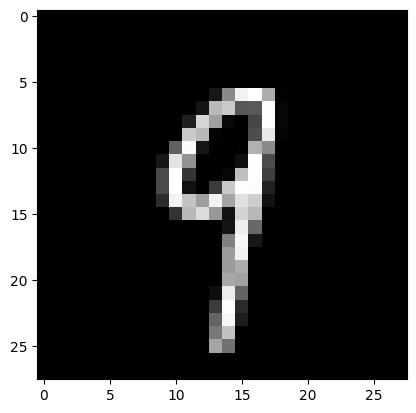

labels:  9


In [98]:
#3
images, labels = dataset[900]
print("images: ",images[:,10:15,10:15])
print("label is: ",labels)

print("torch min: ",torch.max(images),"torch max: ", torch.min(images))

#denormalising image data which was normalised before ,for better visual treatment
def denorm(x):
  out = (x+1)/2
  return out.clamp(0,1)

images=denorm(images)
plt.imshow(images[0], cmap='gray')
plt.show()
print("labels: ", labels)

images shape:  torch.Size([1, 28, 28])
label batch:  tensor([6, 2, 7, 4, 7, 9, 7, 6, 4, 6, 3, 7, 6, 1, 6, 0, 8, 4, 7, 6, 9, 3, 5, 5,
        6, 0, 8, 3, 1, 7, 1, 1, 3, 1, 2, 8, 5, 1, 7, 9, 4, 1, 3, 5, 1, 0, 3, 6,
        2, 9, 3, 8, 9, 3, 2, 9, 0, 2, 1, 5, 1, 7, 9, 2, 8, 7, 7, 1, 7, 2, 3, 6,
        0, 8, 3, 3, 4, 7, 1, 7, 7, 7, 0, 4, 4, 2, 7, 4, 9, 1, 8, 9, 6, 4, 9, 0,
        4, 6, 5, 3])


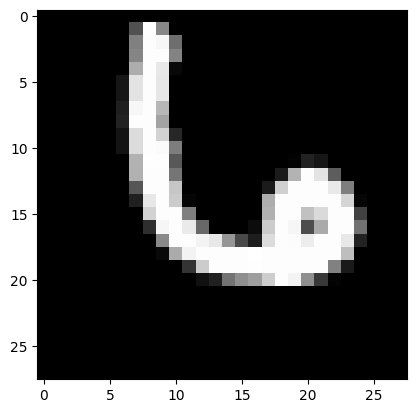

In [99]:
#4
batch_size=100
trainloader = DataLoader(dataset, batch_size, shuffle=True)

for images_batch, labels_batch in trainloader:
  pass
print("images shape: ",images.shape)
plt.imshow(images_batch[0][0], cmap='gray')
print("label batch: ",labels_batch)

In [100]:
#5
#defining the discriminator model
image_size=784
hidden_size=256
discriminator=nn.Sequential(#feed forward nn
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2), # leaky relu is slightly different from relu, which multiplies the value passed as an argument when x is negative
    #where the relu gives 0 values to the gradient , and leaky relu leaks some negatives values to the gradient , not only 0s
                    #in order for the model to learn and complex patterns
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),

    nn.Linear(hidden_size, 1),
    nn.Sigmoid() # sigmoid activation function is used to predict probablities between 0 and 1.
)

In [101]:
discriminator

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): LeakyReLU(negative_slope=0.2)
  (4): Linear(in_features=256, out_features=1, bias=True)
  (5): Sigmoid()
)

In [102]:
#6
#defining the generator model
latent_size=64 # this is the input to the generator model which acts as a seed to this model to predict complex patterns and outputs
# provides the generator with more information
generator=nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(), #relu gives good result in generator and leaky relu gives good results in discriminator.

    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),

    nn.Linear(hidden_size, image_size),
    nn.Tanh()#hyperbolic tangent function from -1 to 1

)

In [103]:
generator

Sequential(
  (0): Linear(in_features=64, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=784, bias=True)
  (5): Tanh()
)

In [104]:
#7 generating images
prediction = generator(torch.randn(2,latent_size))
print("prediction is: ", prediction)
print("prediction shape: ",prediction.shape)

prediction is:  tensor([[ 0.0539, -0.0136,  0.0949,  ..., -0.1014,  0.2532, -0.0727],
        [-0.0471, -0.0587, -0.0405,  ...,  0.0737,  0.1955,  0.1233]],
       grad_fn=<TanhBackward0>)
prediction shape:  torch.Size([2, 784])


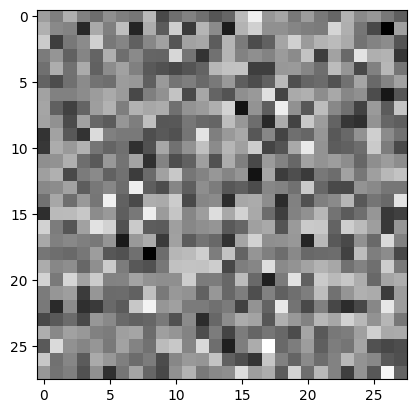

In [105]:
#reshape the picture back to its size, denormalize the picture and then plot the images 8
generated=denorm(prediction.reshape(-1,28,28)).detach()
plt.imshow(generated[0],cmap='gray')

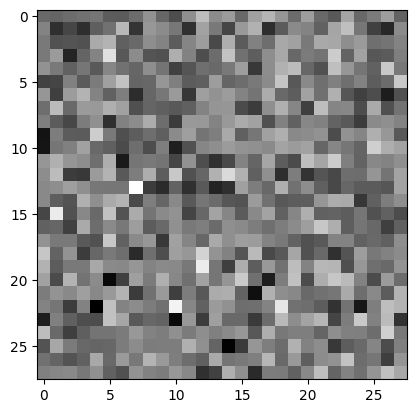

In [106]:
plt.imshow(generated[1],cmap='gray')

In [107]:
#9 loss function discriminator , as it is a binary classification model, we can use binary cross entropy loss
loss_fn=nn.BCELoss()

In [108]:
#10 discriminator and generator optimizer
disc_opt=torch.optim.Adam(discriminator.parameters(), lr=0.0002)
gener_opt=torch.optim.Adam(generator.parameters(), lr=0.0002)

In [109]:
#11 creating a reset grad function
def reset_grad():
  discriminator.zero_grad()
  generator.zero_grad()

In [110]:
#12 discriminator training function
def discriminator_training(images):

  #creating the labels for real and fake images
  real_label = torch.ones(batch_size,1)
  fake_label = torch.zeros(batch_size,1)

  #real image loss
  discriminator_output = discriminator(images)
  discriminator_real_loss = loss_fn(discriminator_output, real_label)
  real_score = discriminator_output

  #fake image loss
  images = torch.randn(batch_size, latent_size)
  fake_images = generator(images)
  discriminator_output = discriminator(fake_images)
  discriminator_fake_loss = loss_fn(discriminator_output, fake_label)
  fake_score = discriminator_output

  #combine both the losses
  total_d_loss = discriminator_real_loss+discriminator_fake_loss

  #reset all the gradients
  reset_grad()

  #compute the gradients
  total_d_loss.backward()

  #update the weights
  disc_opt.step()

  return total_d_loss, real_score, fake_score

In [111]:
#13 generator training function
def generator_training():

  #create fake images and calculate the gen loss
  images = torch.randn(batch_size,latent_size)
  fake_images = generator(images)
  labels = torch.ones(batch_size,1) #trick to fool the discriminator think that the predicted labels are close to one.
  gen_loss = loss_fn(discriminator(fake_images),labels) #to make the generator better

  #backpropogation
  reset_grad()
  gen_loss.backward()
  gener_opt.step()

  return gen_loss, fake_images

In [112]:
#14 training the model and inspecting the results while training
import os

dir='sample'
if not os.path.exists(dir):
  os.makedirs(dir)

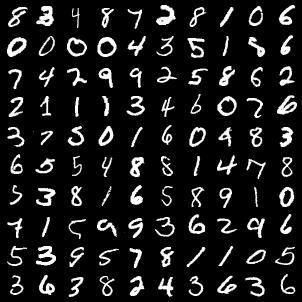

In [113]:
#15 lets save some real mnist images and put inside the directory
from IPython.display import Image
from torchvision.utils import save_image

for images,_ in trainloader:
  images=images.reshape(images.size(0),1,28,28)
  save_image(denorm(images),os.path.join(dir, 'sample_real_image.png'),nrow=10)
  break

Image(os.path.join(dir, 'sample_real_image.png'))

saving....... fake_images12.png


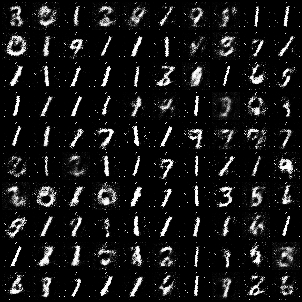

In [114]:
#16 saving all the fake images for visual inspection

sample_vector = torch.randn(batch_size,latent_size)

def save_fake_images(index):
  fake_images = generator(sample_vector)
  fake_images=fake_images.reshape(fake_images.size(0),1,28,28)
  fake_fname=f'fake_images{index}.png'
  print("saving.......",fake_fname)
  save_image(denorm(fake_images), os.path.join(dir,fake_fname),nrow=10)

#before training
save_fake_images(12)
Image(os.path.join(dir, 'fake_images.png'))

In [117]:
#17 we are now ready to train the model, first train the discriminator then the generator

nepochs=100
d_losses,g_losses,real_scores,fake_scores=[],[],[],[] #list for storing the losses and the scores

for epoch in range(nepochs): # main training loop
  for images,_ in trainloader: #putting the training loader in the training loop

    images = images.reshape(batch_size,-1) # loading a batch of images by reshaping it.

    total_d_loss, real_score, fake_score = discriminator_training(images) # training the discriminator

    gen_losses, fake_images = generator_training() # training the generator

    d_losses.append(total_d_loss.item()) #appending all the values to be displayed in a list
    g_losses.append(gen_losses.item()) # same as above

    real_scores.append(real_score.mean().item()) # same as above
    fake_scores.append(fake_score.mean().item()) # same as above

  print(f"epoch{epoch+1}/{nepochs}: ") # display the values.

  print(f"discriminator loss: {total_d_loss.item():.4f}")
  print(f"generator loss: {gen_losses.item():.4f}")

  print(f"real score: {real_score.mean().item():.2f}")
  print(f"fake score: {fake_score.mean().item():.2f}")


  save_fake_images(epoch+1) # saving each fake image after each epoch





epoch1/100: 
discriminator loss: 0.2691
generator loss: 4.2346
real score: 0.95
fake score: 0.14
saving....... fake_images1.png
epoch2/100: 
discriminator loss: 0.5265
generator loss: 2.6977
real score: 0.88
fake score: 0.25
saving....... fake_images2.png
epoch3/100: 
discriminator loss: 0.4055
generator loss: 3.6490
real score: 0.88
fake score: 0.18
saving....... fake_images3.png
epoch4/100: 
discriminator loss: 0.0715
generator loss: 3.9508
real score: 0.97
fake score: 0.03
saving....... fake_images4.png
epoch5/100: 
discriminator loss: 0.1398
generator loss: 5.9004
real score: 0.93
fake score: 0.02
saving....... fake_images5.png
epoch6/100: 
discriminator loss: 0.0848
generator loss: 4.5296
real score: 0.98
fake score: 0.05
saving....... fake_images6.png
epoch7/100: 
discriminator loss: 0.1419
generator loss: 6.5098
real score: 0.98
fake score: 0.03
saving....... fake_images7.png
epoch8/100: 
discriminator loss: 0.1894
generator loss: 5.9936
real score: 0.97
fake score: 0.05
saving.

In [118]:
#save the model 18
torch.save(generator.state_dict(),'generator.ckpt')
torch.save(discriminator.state_dict(),'discriminator.ckpt')

In [3]:
import os
import re

# Directory containing your images
dir = "sample"

# Gather all files with 'fake_images' in their names
files = [f for f in os.listdir(dir) if 'fake_images' in f]

# Sort files numerically based on the digits in their names
files.sort(key=lambda x: int(re.search(r'(\d+)', x).group(1)))

# Rename files with proper zero padding
for i, fname in enumerate(files, start=1):
    src = os.path.join(dir, fname)
    dst = os.path.join(dir, f"fake_images-{i:04d}.png")  # Zero-padded to 4 digits
    os.rename(src, dst)

print("Files renamed successfully!")


FileNotFoundError: [Errno 2] No such file or directory: 'sample'

In [119]:
# generate a video of the process 19
import cv2
import os
from IPython.display import FileLink

vid_name = "generative_adverserial_NN.avi"

files=[os.path.join(dir, f) for f in os.listdir(dir) if 'fake_images' in f]
files.sort()

out=cv2.VideoWriter(vid_name,cv2.VideoWriter_fourcc(*'MP4V'),8,(302,302))
[out.write(cv2.imread(fname)) for fname in files]
out.release()
FileLink('generative_adverserial_NN.avi')


KeyboardInterrupt: 